In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [18]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml.model_selection as dcv

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random
import imblearn as imblearn
from sklearn.preprocessing import MinMaxScaler

import Modeling_Helper
import Processing

import optuna
from optuna.samplers import TPESampler


import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
import statsmodels.api as sm


# Predictive Modeling



In [20]:
class DataPrep:
    def __init__(
        self,
        data_path = './data/merged_data.csv',
        cont_vars = [
            'duration',
            'num_channels',
            'channel_mobile', 
            'channel_social', 
            'channel_web',
            'age',  
            'income',
            'membership_days',
            'difficulty'],
        cat_vars = [
            'offer_id',
            'offer_type',
            'offer_reward',
            'gender', 
            'membership_month', 
            'membership_year'],
        y_var = 'successful_offer'
    
    ):
        """
        Initialises DataPrep
        This class is used to prepare the data

        :param portfolio_path: (str) path to portfolio data
        :param profile_path: (str) path to profile data
        :param transcript_path: (str) path to transcript

        """
        self.data_path = data_path
        self.data = pd.read_csv(self.data_path)
        self.cont_vars = cont_vars
        self.cat_vars = cat_vars
        self.y_var = y_var
    
        self.modeling_data = self.data[[
                'person',
                'offer_id',
                'time_received',
                'offer_type',
                'duration',
                'offer_reward',
                'difficulty',
                'num_channels',
                'channel_email', 
                'channel_mobile', 
                'channel_social', 
                'channel_web',
                'gender', 
                'age',  
                'income',
                'membership_days',
                'membership_month', 
                'membership_year',
                'successful_offer'   
            ]]

        self.features = self.cont_vars+self.cat_vars
    
    def prep_data_logistic(self):
        for i in self.cat_vars:
            y = pd.get_dummies(self.modeling_data[i], prefix=i, drop_first=True)
            y = y.astype('int64')
            self.features = self.features + y.columns.tolist()
            self.features = [x for x in self.features if x != i]
            self.modeling_data = pd.concat([self.modeling_data, y], axis=1)


In [21]:
data_prep = DataPrep()
data_prep.prep_data_logistic()
modeling_data = data_prep.modeling_data
modeling_data.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,...,membership_month_8.0,membership_month_9.0,membership_month_10.0,membership_month_11.0,membership_month_12.0,membership_year_2014.0,membership_year_2015.0,membership_year_2016.0,membership_year_2017.0,membership_year_2018.0
0,user_100,bogo_7_10,336.0,bogo,7.0,10,10,3,1,1,...,0,0,0,0,0,0,0,1,0,0
1,user_100,discount_10_5,0.0,discount,10.0,5,20,2,1,0,...,0,0,0,0,0,0,0,1,0,0
2,user_100,discount_10_5,576.0,discount,10.0,5,20,2,1,0,...,0,0,0,0,0,0,0,1,0,0
3,user_100,informational_4,408.0,informational,4.0,0,0,3,1,1,...,0,0,0,0,0,0,0,1,0,0
4,user_10002,informational_4,336.0,informational,4.0,0,0,3,1,1,...,0,0,0,1,0,0,1,0,0,0


In [26]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, data_prep.y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()

In [28]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(train_df.loc[:, data_prep.features])
train_df.loc[: , data_prep.features] = scaler.transform(train_df.loc[: , data_prep.features])
test_df.loc[: , data_prep.features] = scaler.transform(test_df.loc[: , data_prep.features])

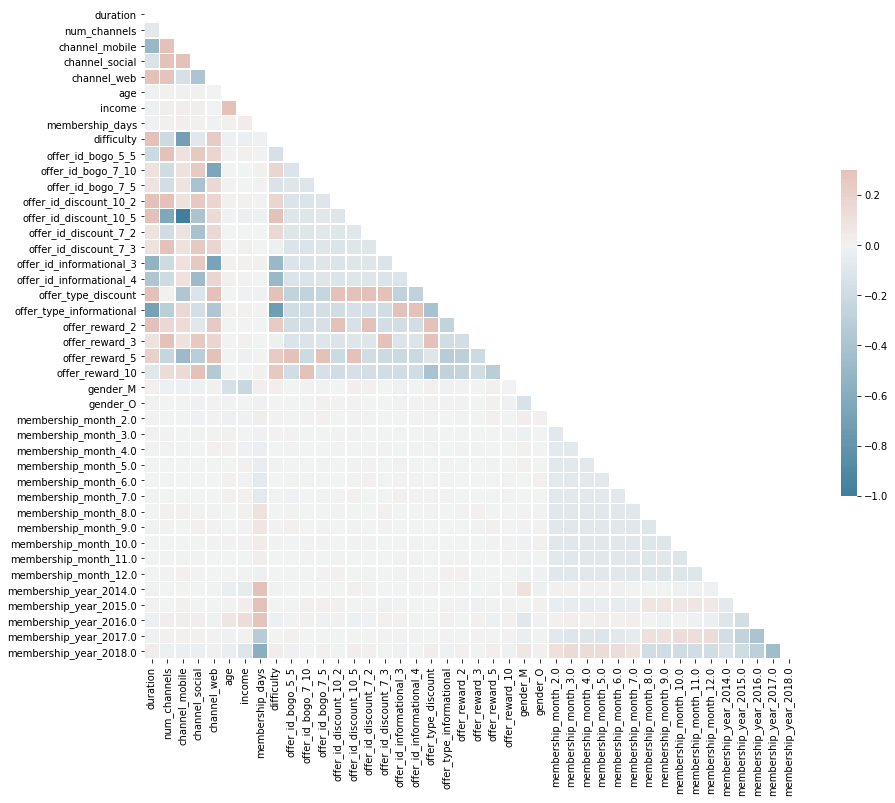

In [30]:
cor_df = Processing.correlation_map(train_df, data_prep.features)

In [32]:
sm = imblearn.over_sampling.RandomOverSampler(random_state=2021)
X_train_res, y_train_res = sm.fit_resample(train_df[data_prep.features], train_df[data_prep.y_var].ravel())
X_train_res[data_prep.y_var] = y_train_res

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (93062, 43)
After OverSampling, the shape of train_y: (93062,) 

After OverSampling, counts of label '1': 46531
After OverSampling, counts of label '0': 46531


In [37]:
len(data_prep.features)

42

In [35]:
import statsmodels.api as sm
X_train_res = sm.add_constant(X_train_res, has_constant='add')
logit_model=sm.Logit(X_train_res[data_prep.y_var], X_train_res[['const']+data_prep.features])
logit_model=logit_model.fit()
print(logit_model.summary2())

         Current function value: 0.607410
         Iterations: 35


LinAlgError: Singular matrix

************** Performance: Train Set **************** 

Accuracy: 0.67
Precision: 0.65
Recall: 0.71
F1: 0.68


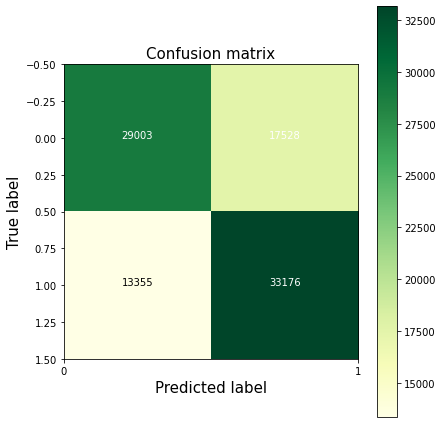

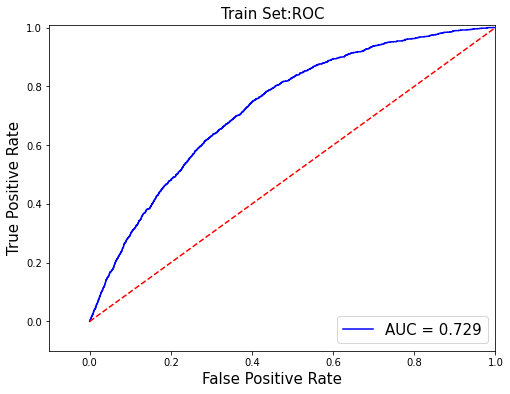

In [13]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, X_train_res, ['const']+features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()

************** Performance: Test Set **************** 

Accuracy: 0.63
Precision: 0.05
Recall: 0.67
F1: 0.1


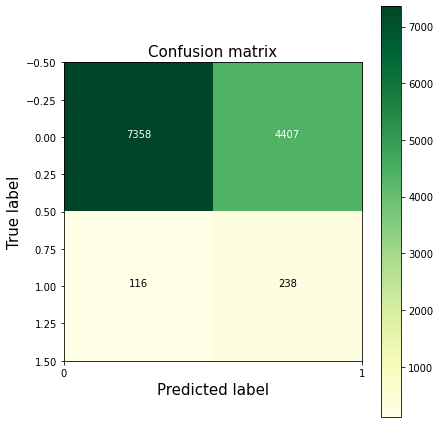

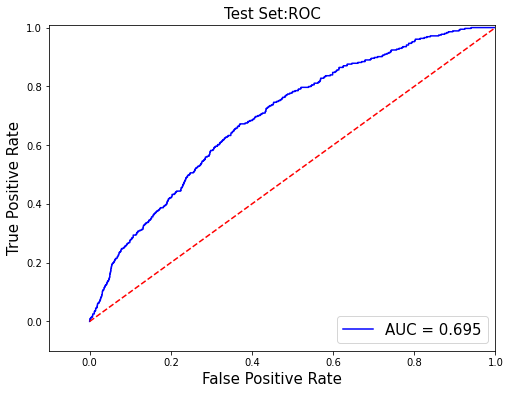

In [14]:
test_df = sm.add_constant(test_df, has_constant='add')
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, test_df, ['const']+features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

In [3]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

In [4]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [5]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [6]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
print(len(train_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7981579560973985 0.20184204390260152
0.029046595580410242 0.029210330885386583
33.42744252873563


In [7]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

In [8]:
params = {'objective': "binary", 'metric': ['binary_logloss', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
              
            'max_depth':5, 
            'num_leaves':10, 
            'learning_rate': 0.2,
            'num_iterations':1000,
            'min_data_in_leaf': 300,
            'scale_pos_weight':scale_pos_weight_val
         }

gbm_model = lgb.train(params,
            train_data,
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
                     )

Found `num_iterations` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


************** Performance: Train Set **************** 

Accuracy: 0.88
Precision: 0.19
Recall: 1.0
F1: 0.32


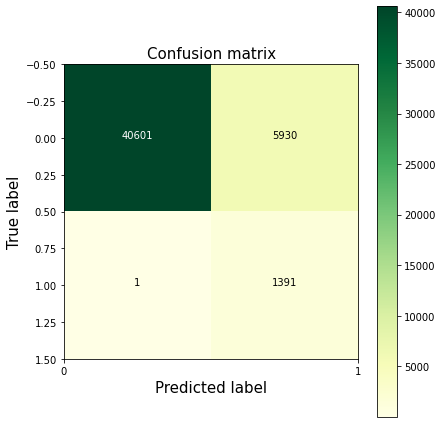

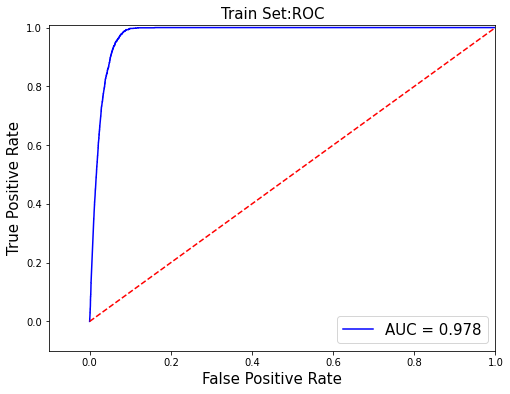

************** Performance: Test Set **************** 

Accuracy: 0.85
Precision: 0.06
Recall: 0.29
F1: 0.1


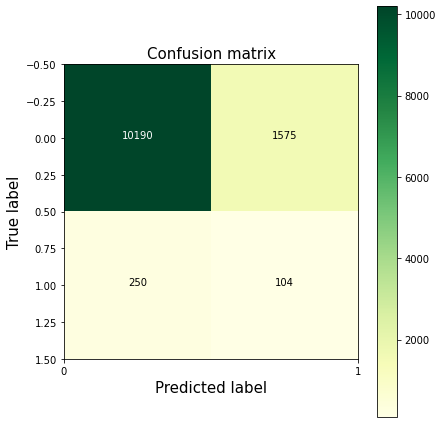

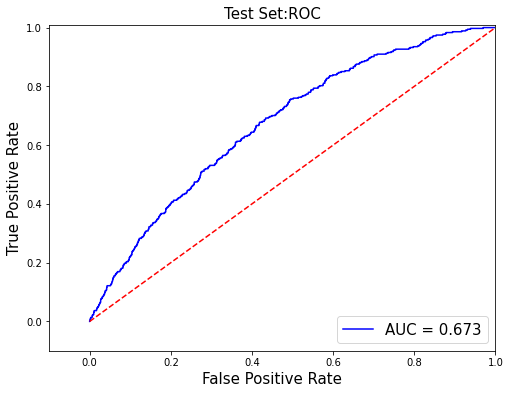

In [9]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, test_df, features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

In [10]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


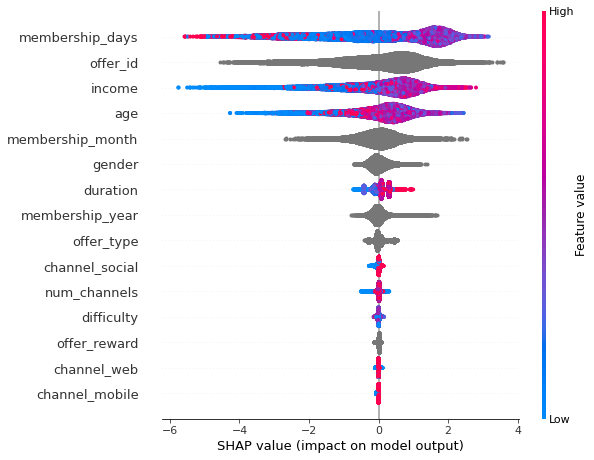

In [11]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)

In [9]:
modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']

In [10]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [11]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
print(len(train_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7984077812198128 0.2015922187801872
0.029100087613167007 0.02899867812293457
33.36415770609319


In [14]:
sampler = TPESampler(seed=2021)  
study = optuna.create_study(sampler = sampler, direction="maximize")
study.optimize(Modeling_Helper.BayesianOpt(train_df, features, y_var, scale_pos_weight_val), n_trials=100)

[I 2021-11-29 15:36:19,428] A new study created in memory with name: no-name-6643f4d6-bf3e-4aca-8416-569395d2ccc4
[I 2021-11-29 15:36:48,448] Trial 0 finished with value: 0.11309781035250034 and parameters: {'learning_rate': 0.0377391257196892, 'num_leaves': 45, 'colsample_bytree': 0.311157725382719, 'reg_alpha': 0.06980640530295552, 'reg_lambda': 4.915069954353206, 'max_depth': 5, 'min_child_samples': 148, 'subsample': 0.8023403430208751, 'n_estimators': 1493}. Best is trial 0 with value: 0.11309781035250034.
[I 2021-11-29 15:37:10,858] Trial 1 finished with value: 0.11111240402162112 and parameters: {'learning_rate': 0.10985555325894224, 'num_leaves': 7, 'colsample_bytree': 0.2468570280704288, 'reg_alpha': 3.958019320953226, 'reg_lambda': 0.4613919861163953, 'max_depth': 4, 'min_child_samples': 359, 'subsample': 0.6932197668943921, 'n_estimators': 1946}. Best is trial 0 with value: 0.11309781035250034.
[I 2021-11-29 15:37:44,555] Trial 2 finished with value: 0.1100649018418246 and pa

[I 2021-11-29 15:54:01,527] Trial 20 finished with value: 0.11611691740759032 and parameters: {'learning_rate': 0.021091124469863266, 'num_leaves': 50, 'colsample_bytree': 0.7595859838046863, 'reg_alpha': 0.02006614161782962, 'reg_lambda': 1.1206465330018285, 'max_depth': 14, 'min_child_samples': 227, 'subsample': 0.9258033626967777, 'n_estimators': 1168}. Best is trial 19 with value: 0.14152844269148004.
[I 2021-11-29 15:54:58,186] Trial 21 finished with value: 0.13569554672406198 and parameters: {'learning_rate': 0.0010564635078824474, 'num_leaves': 48, 'colsample_bytree': 0.9121774132569622, 'reg_alpha': 0.012110206548878798, 'reg_lambda': 1.1127096405786758, 'max_depth': 20, 'min_child_samples': 294, 'subsample': 0.8036450224570105, 'n_estimators': 1268}. Best is trial 19 with value: 0.14152844269148004.
[I 2021-11-29 15:55:56,790] Trial 22 finished with value: 0.13486596232653353 and parameters: {'learning_rate': 0.0010606589827079817, 'num_leaves': 48, 'colsample_bytree': 0.99642

[I 2021-11-29 16:07:47,979] Trial 40 finished with value: 0.10513325444616219 and parameters: {'learning_rate': 0.04825763182452712, 'num_leaves': 42, 'colsample_bytree': 0.9728621076503364, 'reg_alpha': 0.24610507171091725, 'reg_lambda': 0.15238080753879868, 'max_depth': 23, 'min_child_samples': 193, 'subsample': 0.3503539183961863, 'n_estimators': 708}. Best is trial 31 with value: 0.1419151566852487.
[I 2021-11-29 16:08:20,285] Trial 41 finished with value: 0.0 and parameters: {'learning_rate': 0.0014068344784059865, 'num_leaves': 47, 'colsample_bytree': 0.9266630061813697, 'reg_alpha': 0.0312518342839361, 'reg_lambda': 2.7642570517508283, 'max_depth': 26, 'min_child_samples': 502, 'subsample': 0.7687209138693255, 'n_estimators': 613}. Best is trial 31 with value: 0.1419151566852487.
[I 2021-11-29 16:08:56,020] Trial 42 finished with value: 0.13670659761248133 and parameters: {'learning_rate': 0.0018867683173548287, 'num_leaves': 45, 'colsample_bytree': 0.8989481756702321, 'reg_alph

[I 2021-11-29 16:18:08,219] Trial 60 finished with value: 0.14444501653001848 and parameters: {'learning_rate': 0.0016315997857535868, 'num_leaves': 27, 'colsample_bytree': 0.5366655308143199, 'reg_alpha': 0.07088850673123137, 'reg_lambda': 1.329795453959223, 'max_depth': 23, 'min_child_samples': 469, 'subsample': 0.9786795073787806, 'n_estimators': 664}. Best is trial 60 with value: 0.14444501653001848.
[I 2021-11-29 16:18:27,544] Trial 61 finished with value: 0.14505585908392027 and parameters: {'learning_rate': 0.001651540420257919, 'num_leaves': 26, 'colsample_bytree': 0.5546771722017886, 'reg_alpha': 0.11511983596488812, 'reg_lambda': 1.402881028322646, 'max_depth': 25, 'min_child_samples': 470, 'subsample': 0.966533554147176, 'n_estimators': 660}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:18:46,474] Trial 62 finished with value: 0.14395856519425043 and parameters: {'learning_rate': 0.0016749421777113734, 'num_leaves': 25, 'colsample_bytree': 0.54064737378

[I 2021-11-29 16:26:00,978] Trial 80 finished with value: 0.1205143992592462 and parameters: {'learning_rate': 0.002474878388945733, 'num_leaves': 26, 'colsample_bytree': 0.5426246792608881, 'reg_alpha': 0.313271617386336, 'reg_lambda': 1.4050008159764267, 'max_depth': 22, 'min_child_samples': 197, 'subsample': 0.9817511102745612, 'n_estimators': 803}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:26:59,318] Trial 81 finished with value: 0.11167258232817735 and parameters: {'learning_rate': 0.001911661615944234, 'num_leaves': 32, 'colsample_bytree': 0.5930420941776336, 'reg_alpha': 0.07690129633352104, 'reg_lambda': 2.3611942157410937, 'max_depth': 26, 'min_child_samples': 463, 'subsample': 0.8801981492145364, 'n_estimators': 1787}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:27:19,017] Trial 82 finished with value: 0.14207469250384364 and parameters: {'learning_rate': 0.0018732900800033955, 'num_leaves': 29, 'colsample_bytree': 0.45007201019

Optuna best score = 0.1451


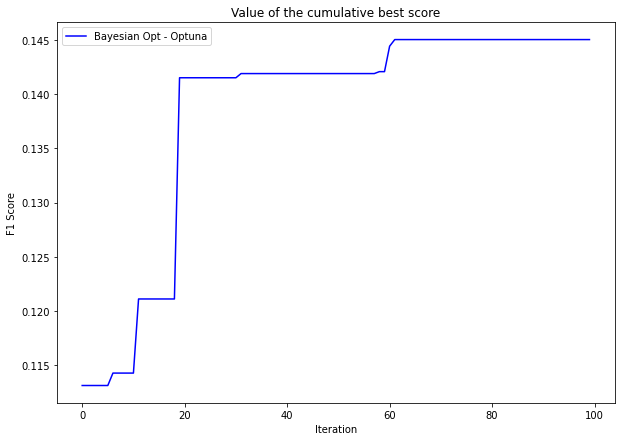

In [15]:
op_tuna_cummax = np.array(study.trials_dataframe()["value"].cummax()) 
print(f'Optuna best score = {op_tuna_cummax[-1]:.4f}')
fig = plt.figure(figsize = (10, 7))
plt.plot(op_tuna_cummax, 'b', label='Bayesian Opt - Optuna')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('Value of the cumulative best score');
plt.legend()

In [16]:
best_params = study.best_params
best_params

{'learning_rate': 0.001651540420257919,
 'num_leaves': 26,
 'colsample_bytree': 0.5546771722017886,
 'reg_alpha': 0.11511983596488812,
 'reg_lambda': 1.402881028322646,
 'max_depth': 25,
 'min_child_samples': 470,
 'subsample': 0.966533554147176,
 'n_estimators': 660}